In [18]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import numpy as np
from slsim.Sources.source import Source
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.LOS.los_individual import LOSIndividual
from slsim.image_simulation import lens_image, rgb_image_from_image_list
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.Util.param_util import gaussian_psf

## Single lens simulation
This notebook walks through the basics of simulating a galaxy-galaxy strong lens using users
own lens parameters.

The notebook goes in three steps:

1. Prepare source and deflector dict of your lens. 
2. Initialize Source, Deflector, and LOSIndividual class
3. Initialize Lens class
4. Use Lens class from 3 in image simulation module to simulate image

## Prepare source and deflector dict of your lens. 

In [5]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [8]:
# Source dict. You can also proviide magnitude in single band. This source dict is
# valid for single sersic_ellipse light profile.
source_dict = {
    "z": 1.5,
    "angular_size": 0.10887651129362959,  # effective radius of a source in arcsec
    "mag_g": 22.5,  # g-band magnitude of a source
    "mag_r": 22,  # r-band magnitude of a source
    "mag_i": 22.2,  # i-band magnitude of a source
    "mag_z": 22.1,  # z-band magnitude of a source
    "mag_y": 22.0,  # y-band magnitude of a source
    "e1": 0.0,  # tangential component of the ellipticity
    "e2": 0.0,  # cross component of the ellipticity
    "n_sersic": 1.5547096361698418,  # sersic index for sersic_ellipse profile
    "center_x": 0.056053505877290584,  # x-position of the center of a source
    "center_y": -0.08071283196326566,
}  # y-position of the center of a source

# Deflector dict. You can also provide magnitude in single band. This deflector dict is
# valid for elliptical power law model.
deflector_dict = {
    "z": 0.5,
    "angular_size": 0.09604418906529916,  # effective radius of the deflector in arcsec
    "mag_g": 20.0,  # g-band magnitude of a deflector
    "mag_r": 19.0,  # r-band magnitude of a deflector
    "mag_i": 18.5,  # i-band magnitude of a deflector
    "mag_z": 18.0,  # z-band magnitude of a deflector
    "mag_y": 17.5,  # y-band magnitude of a deflector
    "theta_E": 2,  # Einstein radius of the deflector
    "e1_light": 0.09096489106609575,  # tangential component of the light ellipticity
    "e2_light": 0.1489400739802363,  # cross component of the light ellipticity
    "e1_mass": 0.1082427319496781,  # tangential component of the mass ellipticity
    "e2_mass": 0.10051583213026649,  # cross component of the mass ellipticity
    "gamma_pl": 2.0,  # power law slope in elliptical power law mass model
    "n_sersic": 2.4362388918558664,  # sersic index of a sersic_ellipse profile of a deflector
    "center_x": 0.10039720005025651,  # x-position of the center of the lens
    "center_y": -0.0002092046265491892,  # y-position of the center of the lens
}

## Initialize Source, Deflector, and LOSIndividual class

In [9]:
source = Source(
    source_dict=source_dict,
    cosmo=cosmo,
    source_type="extended",
    extendedsource_type="single_sersic",
)
deflector = Deflector(
    deflector_type="EPL",
    deflector_dict=deflector_dict,
)
los_class = LOSIndividual(kappa=0, gamma=[-0.005061965833762263, 0.028825761226555197])

## Initialize Lens class

In [5]:
# This is your lens. it contains all the information about your lensing configuration.
lens_class = Lens(
    source_class=source, deflector_class=deflector, cosmo=cosmo, los_class=los_class
)

## Use Lens class from 3 in image simulation module to simulate image

In [16]:
# load your psf kernel and transform matrix.
psf_kernel = gaussian_psf(fwhm=0.9, delta_pix=0.2, num_pix=41)

# let's set pixel to angle transform matrix.
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# These numbers come from some random dp0 cutout variance map. User can use their values.
bkg_std_i = (0.05774509,)  # i-band background noise
bkg_std_r = 0.03247451  # r-band background noise
bkg_std_g = 0.028600888  # g-band background noise

## Simulate images in different bands

In [7]:
image_i = lens_image(
    lens_class=lens_class,
    band="i",
    mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,  # one can provide None
    t_obs=None,
    std_gaussian_noise=bkg_std_i,  # one can provide None
    with_source=True,
    with_deflector=True,
)
image_r = lens_image(
    lens_class=lens_class,
    band="r",
    mag_zero_point=27,
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,
    t_obs=None,
    std_gaussian_noise=bkg_std_r,
    with_source=True,
    with_deflector=True,
)

image_g = lens_image(
    lens_class=lens_class,
    band="g",
    mag_zero_point=27,
    num_pix=61,
    psf_kernel=psf_kernel,
    transform_pix2angle=transform_matrix,
    exposure_time=300,
    t_obs=None,
    std_gaussian_noise=bkg_std_g,
    with_source=True,
    with_deflector=True,
)

In [8]:
# Simulate rgb color image
rgb_image = rgb_image_from_image_list([image_i, image_r, image_g], stretch=0.5)

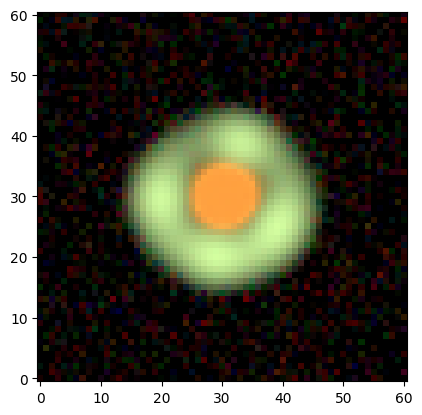

In [9]:
## see rgb image. You can also see images in each band.
plt.imshow(rgb_image, origin="lower")

## Lensed Supernova 

In [3]:
# supernova and host galaxy dict. One can avoid host galaxy information and simulate
# lensed supernova only.
source_dict_sn = {
    "z": 1,
    "ra_off": 0.001,
    "dec_off": -0.002,
    "angular_size": 0.10887651129362959,
    "mag_i": 25,
    "e1": 0.0,
    "e2": 0.0,
    "n_sersic": 1.5547096361698418,
    "center_x": 0.056053505877290584,
    "center_y": -0.08071283196326566,
}
deflector_dict_sn = {
    "z": 0.5,
    "angular_size": 0.09604418906529916,
    "mag_i": 23,
    "theta_E": 1.5,
    "e1_light": 0.09096489106609575,
    "e2_light": 0.1489400739802363,
    "e1_mass": 0.1082427319496781,
    "e2_mass": 0.10051583213026649,
    "gamma_pl": 2.0,
    "n_sersic": 2.4362388918558664,
    "center_x": 0.10039720005025651,
    "center_y": -0.0002092046265491892,
}
kwargs_sn = {
    "pointsource_type": "supernova",
    "extendedsource_type": "single_sersic",
    "variability_model": "light_curve",
    "kwargs_variability": ["supernovae_lightcurve", "i"],
    "sn_type": "Ia",
    "sn_absolute_mag_band": "bessellb",
    "sn_absolute_zpsys": "ab",
    "lightcurve_time": np.linspace(-50, 100, 150),
}

In [6]:
source_sn = Source(
    source_dict=source_dict_sn,
    cosmo=cosmo,
    source_type="point_plus_extended",
    **kwargs_sn
)
deflector_sn = Deflector(
    deflector_type="EPL",
    deflector_dict=deflector_dict_sn,
)

In [10]:
lensed_sn = Lens(
    source_class=source_sn,
    deflector_class=deflector_sn,
    cosmo=cosmo,
    los_class=los_class,
)

In [11]:
lightcurve_time = np.linspace(-50, 100, 150)
mag_i = lensed_sn.point_source_magnitude(band="i", lensed=True, time=lightcurve_time)

/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


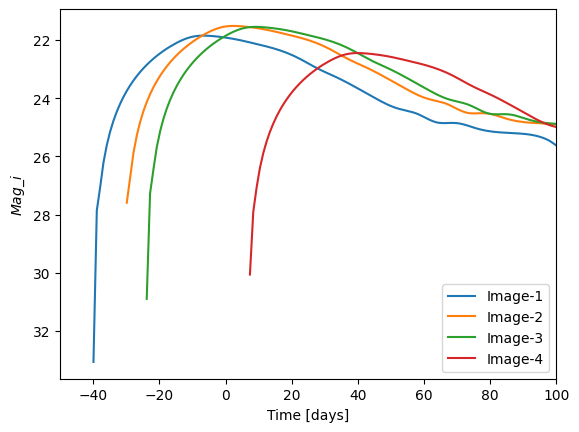

In [12]:
plt.plot(lightcurve_time, mag_i[0][0], label="Image-1")
plt.plot(lightcurve_time, mag_i[0][1], label="Image-2")
plt.plot(lightcurve_time, mag_i[0][2], label="Image-3")
plt.plot(lightcurve_time, mag_i[0][3], label="Image-4")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{i}$")
plt.xlabel("Time [days]")
plt.xlim(-50, 100)
plt.legend()

In [17]:
obs_time = [-10, 0, 10, 20, 25, 30, 35, 40, 45, 50]
sn_image_list = []
for time in obs_time:
    image_i = lens_image(
        lens_class=lensed_sn,
        band="i",
        mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
        num_pix=61,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=30,  # one can provide None
        t_obs=time,
        std_gaussian_noise=bkg_std_i,  # one can provide None
        with_source=True,
        with_deflector=True,
    )
    sn_image_list.append(image_i)

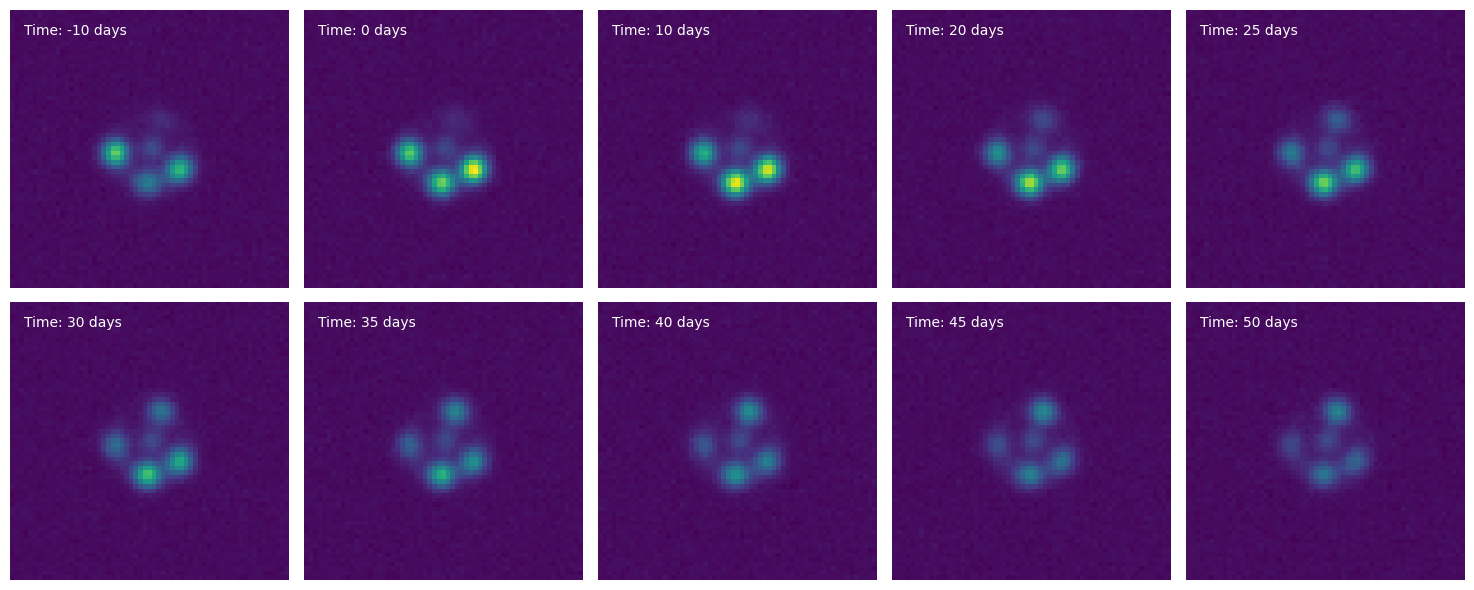

In [19]:
x = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=sn_image_list, time=obs_time, image_type="other"
)

## Lensed Quasar

In [20]:
# quasar and host galaxy dict. One can avoid host galaxy information and simulate
# lensed quasar only.
source_dict_quasar = {
    "z": 1.5,
    "ps_mag_i": 21,
    "angular_size": 0.10887651129362959,
    "mag_i": 20,
    "e1": 0.0,
    "e2": 0.0,
    "n_sersic": 1.5547096361698418,
    "center_x": 0.046053505877290584,
    "center_y": -0.09071283196326566,
}
deflector_dict_quasar = {
    "z": 0.5,
    "angular_size": 0.09604418906529916,
    "mag_i": 18,
    "theta_E": 1.5,
    "e1_light": 0.09096489106609575,
    "e2_light": 0.1489400739802363,
    "e1_mass": 0.1082427319496781,
    "e2_mass": 0.10051583213026649,
    "gamma_pl": 2.0,
    "n_sersic": 2.4362388918558664,
    "center_x": 0.10039720005025651,
    "center_y": -0.0002092046265491892,
}

variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}
kwargs_quasar = {
    "pointsource_type": "quasar",
    "extendedsource_type": "single_sersic",
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "i", "r"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, 1000, 1000),
}

In [21]:
source_quasar = Source(
    source_dict=source_dict_quasar,
    cosmo=cosmo,
    source_type="point_plus_extended",
    **kwargs_quasar
)
deflector_quasar = Deflector(
    deflector_type="EPL",
    deflector_dict=deflector_dict_quasar,
)

In [22]:
lensed_quasar = Lens(
    source_class=source_quasar,
    deflector_class=deflector_quasar,
    cosmo=cosmo,
    los_class=los_class,
)

In [23]:
lightcurve_time = np.linspace(0, 1000, 1000)
mag_i_q = lensed_quasar.point_source_magnitude(
    band="i", lensed=True, time=lightcurve_time
)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


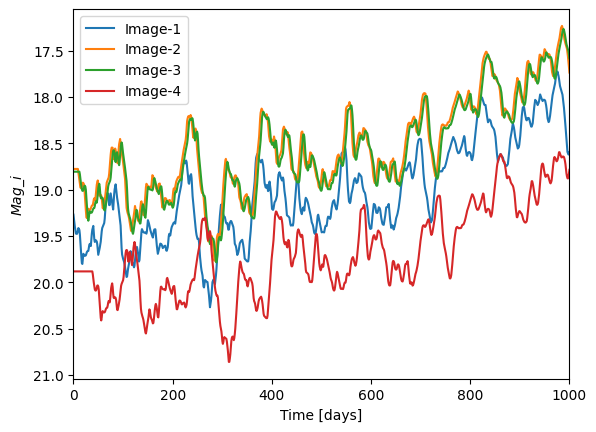

In [24]:
plt.plot(lightcurve_time, mag_i_q[0][0], label="Image-1")
plt.plot(lightcurve_time, mag_i_q[0][1], label="Image-2")
plt.plot(lightcurve_time, mag_i_q[0][2], label="Image-3")
plt.plot(lightcurve_time, mag_i_q[0][3], label="Image-4")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{i}$")
plt.xlabel("Time [days]")
plt.xlim(0, 1000)
plt.legend()

In [25]:
obs_time_q = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
quasar_image_list = []
for time in obs_time_q:
    image_i = lens_image(
        lens_class=lensed_quasar,
        band="i",
        mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
        num_pix=61,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=30,  # one can provide None
        t_obs=time,
        std_gaussian_noise=bkg_std_i,  # one can provide None
        with_source=True,
        with_deflector=True,
    )
    quasar_image_list.append(image_i)

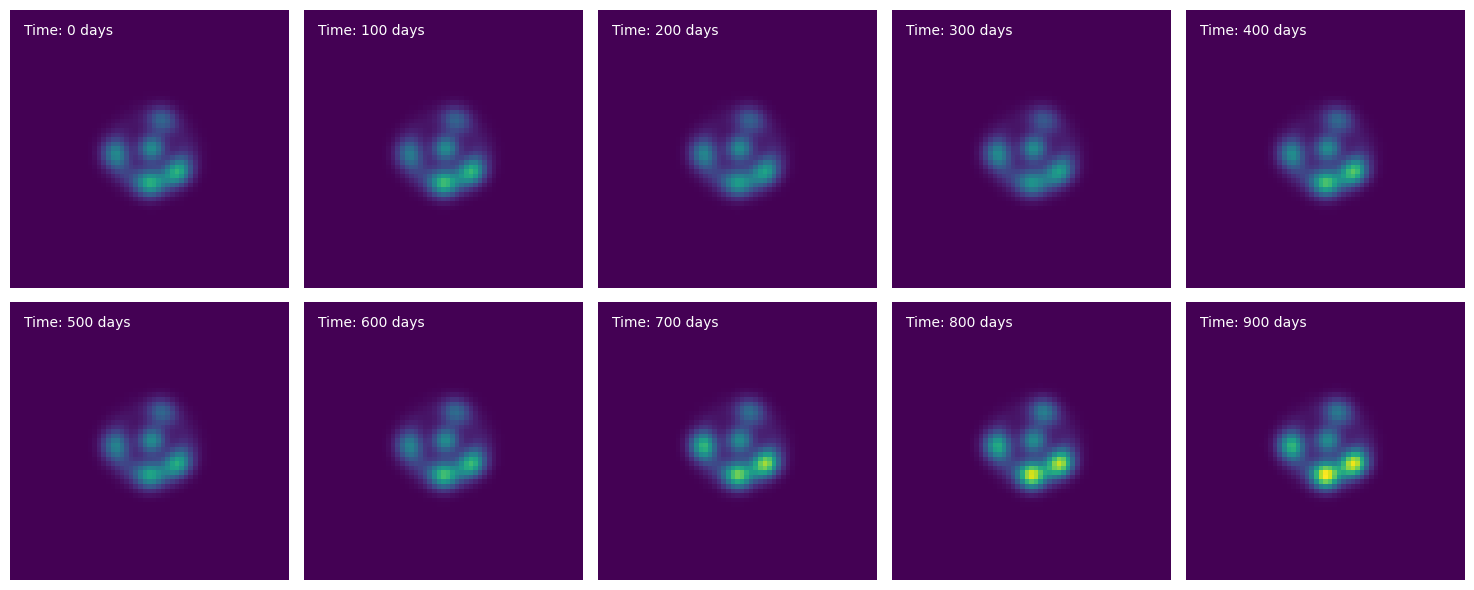

In [26]:
x = create_image_montage_from_image_list(
    num_rows=2,
    num_cols=5,
    images=quasar_image_list,
    time=obs_time_q,
    image_type="other",
)

## General lightcurve

In [27]:
# This is a lightcurve of a supernova at z=0.8. One can pass lightcurve of any object.
magnitude_i = np.array(
    [
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        29.23200965,
        27.77844285,
        26.71974751,
        26.01862265,
        25.49515022,
        25.07844229,
        24.73309722,
        24.43879779,
        24.18285713,
        23.95681729,
        23.75475557,
        23.57237339,
        23.40646597,
        23.25438869,
        23.11442554,
        22.98904818,
        22.88336651,
        22.80220793,
        22.74940102,
        22.71902597,
        22.70358118,
        22.6962224,
        22.69297641,
        22.69455612,
        22.70442779,
        22.72602398,
        22.75924192,
        22.8020101,
        22.85126533,
        22.90412454,
        22.95959202,
        23.01834642,
        23.08100876,
        23.14849981,
        23.22211966,
        23.30359814,
        23.39507731,
        23.49628529,
        23.60394332,
        23.71301845,
        23.81925088,
        23.92118927,
        24.02131306,
        24.12340934,
        24.2291926,
        24.33713797,
        24.4443583,
        24.54767644,
        24.64488685,
        24.73613521,
        24.82212321,
        24.9033994,
        24.98020785,
        25.05283199,
        25.12185914,
        25.18820313,
        25.25319532,
        25.31868399,
        25.38544028,
        25.45177641,
        25.5136614,
        25.56634629,
        25.60712246,
        25.64000445,
        25.67006928,
        25.70167611,
        25.73645967,
        25.77247386,
        25.80724141,
        25.83876421,
        25.86711622,
        25.89272561,
        25.91616866,
        25.93808172,
        25.95917506,
        25.98026748,
        26.00220239,
        26.02588231,
        26.05229401,
        26.08253359,
        26.11784636,
        26.1597366,
        26.21118213,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
        np.inf,
    ]
)

time = np.linspace(-50, 100, 100)

In [28]:
# Lightcurve and associated host galaxy information.
# Here one can pass multiband lightcurve. We have provided here only i-band lightcurve
source_dict_lightcurve = {
    "z": 0.8,
    "ra_off": 0.001,
    "dec_off": 0.005,
    "MJD": time,
    "ps_mag_i": magnitude_i,
    "angular_size": 0.10887651129362959,
    "mag_i": 23,
    "e1": 0.0,
    "e2": 0.0,
    "n_sersic": 1.5547096361698418,
    "center_x": 0.046053505877290584,
    "center_y": -0.09071283196326566,
}
deflector_dict_lightcurve = {
    "z": 0.5,
    "angular_size": 0.09604418906529916,
    "mag_i": 21,
    "theta_E": 1.5,
    "e1_light": 0.09096489106609575,
    "e2_light": 0.1489400739802363,
    "e1_mass": 0.1082427319496781,
    "e2_mass": 0.10051583213026649,
    "gamma_pl": 2.0,
    "n_sersic": 2.4362388918558664,
    "center_x": 0.10039720005025651,
    "center_y": -0.0002092046265491892,
}
kwargs_lightcurve = {
    "pointsource_type": "general_lightcurve",
    "extendedsource_type": "single_sersic",
    "variability_model": "light_curve",
}

In [29]:
source_lightcurve = Source(
    source_dict=source_dict_lightcurve,
    cosmo=cosmo,
    source_type="point_plus_extended",
    **kwargs_lightcurve
)
deflector_lightcurve = Deflector(
    deflector_type="EPL",
    deflector_dict=deflector_dict_lightcurve,
)

In [31]:
lensed_lightcurve = Lens(
    source_class=source_lightcurve,
    deflector_class=deflector_lightcurve,
    cosmo=cosmo,
    los_class=los_class,
)

In [32]:
lightcurve_time = np.linspace(-50, 100, 100)
mag_i_lc = lensed_lightcurve.point_source_magnitude(
    band="i", lensed=True, time=lightcurve_time
)

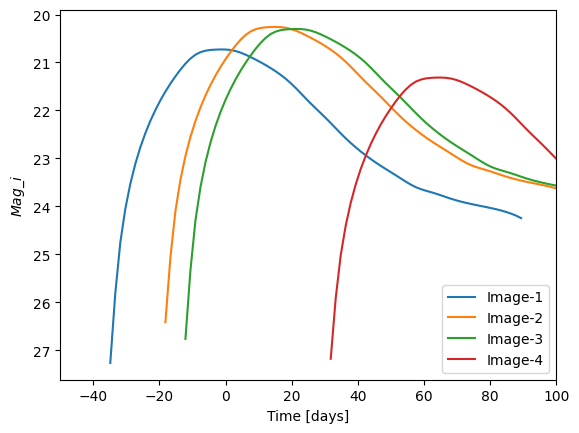

In [33]:
plt.plot(lightcurve_time, mag_i_lc[0][0], label="Image-1")
plt.plot(lightcurve_time, mag_i_lc[0][1], label="Image-2")
plt.plot(lightcurve_time, mag_i_lc[0][2], label="Image-3")
plt.plot(lightcurve_time, mag_i_lc[0][3], label="Image-4")
plt.gca().invert_yaxis()
plt.ylabel(r"$Mag\_{i}$")
plt.xlabel("Time [days]")
plt.xlim(-50, 100)
plt.legend()

In [35]:
obs_time_lc = [-5, 0, 10, 20, 30, 40, 50, 60, 70, 80]
lc_image_list = []
for time in obs_time_lc:
    image_i = lens_image(
        lens_class=lensed_lightcurve,
        band="i",
        mag_zero_point=27,  # lsst coadd images have zero point magnitude of 27.
        num_pix=61,
        psf_kernel=psf_kernel,
        transform_pix2angle=transform_matrix,
        exposure_time=30,  # one can provide None
        t_obs=time,
        std_gaussian_noise=bkg_std_i,  # one can provide None
        with_source=True,
        with_deflector=True,
    )
    lc_image_list.append(image_i)

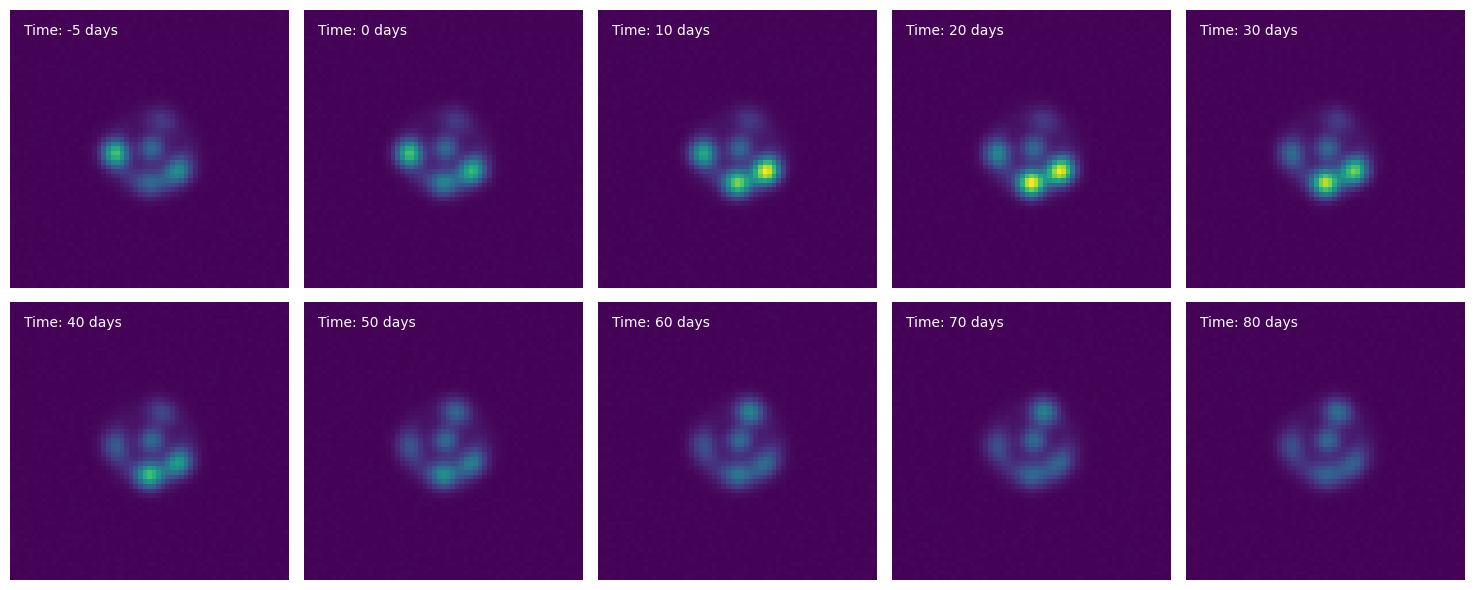

In [36]:
x = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=lc_image_list, time=obs_time_lc, image_type="other"
)